<a href="https://colab.research.google.com/github/gparrag/MIAD_ML_and_NLP/blob/main/Semana%202/S2TC1_RandomForests_Boosting%20-%20Solucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [21]:
# Celda 1
from sklearn.metrics import accuracy_score
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  
    
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    j, split, gain = best_split(X, y, num_pct)
    
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0) 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)

y_pred_mantree=tree_predict(X_test, tree)
accuracy=accuracy_score(y_test,y_pred_mantree)
accuracy

0.8879907621247113

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [31]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
import numpy as np
feature_cols=X_train.columns
max_features=int(np.log(len(feature_cols)))
clf_Bagg = BaggingClassifier(n_estimators=10, random_state=0,max_features=max_features)
clf_Bagg.fit(X_train, y_train)

y_pred_bagg=clf_Bagg.predict(X_test)
accuracy=accuracy_score(y_test,y_pred_bagg)
accuracy

0.8493071593533488

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
accuracy

0.8432448036951501

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

20


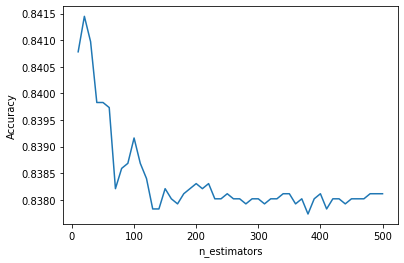

In [ ]:
# Celda 5
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

accuracy_scores_n_estimators = []

estimator_range = range(10, 510, 10)

for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores_n_estimators.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

plt.plot(estimator_range, accuracy_scores_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

max_index = accuracy_scores_n_estimators.index(max(accuracy_scores_n_estimators))
print(estimator_range[max_index])

9


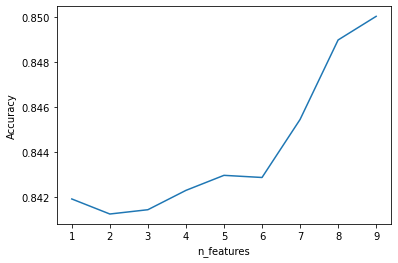

In [ ]:
accuracy_scores_max_features = []
feature_cols=X_train.columns
feature_range = range(1, len(feature_cols)+1)

for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=20, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores_max_features.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())
    
plt.plot(feature_range, accuracy_scores_max_features)
plt.xlabel('n_features')
plt.ylabel('Accuracy')

max_index = accuracy_scores_max_features.index(max(accuracy_scores_max_features))
print(feature_range[max_index])

5


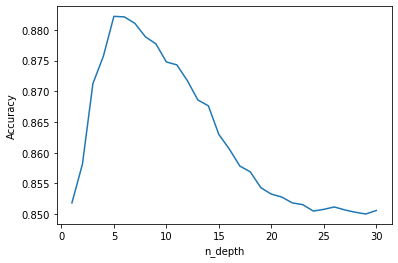

In [ ]:
accuracy_scores_max_depth = []
depth_range = range(1, 31)

for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=20,max_features=9, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores_max_depth.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())
    
plt.plot(depth_range, accuracy_scores_max_depth)
plt.xlabel('n_depth')
plt.ylabel('Accuracy')

max_index = accuracy_scores_max_depth.index(max(accuracy_scores_max_depth))
print(depth_range[max_index])

In [ ]:
clf_tunning = RandomForestClassifier(n_estimators=20,max_features=9, max_depth=5, random_state=1, n_jobs=-1)
clf_tunning.fit(X_train, y_train)

y_pred_tunning=clf_tunning.predict(X_test)
accuracy=accuracy_score(y_test,y_pred_tunning)
accuracy

0.8888568129330254

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [ ]:
# Celda 6
from xgboost import XGBClassifier
clf_XG = XGBClassifier(verbosity = 0)
clf_XG

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0)

In [ ]:
clf_XG.fit(X_train, y_train)

y_pred_XG=clf_XG.predict(X_test)
accuracy=accuracy_score(y_test,y_pred_XG)
accuracy

0.8856812933025404

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

0.1


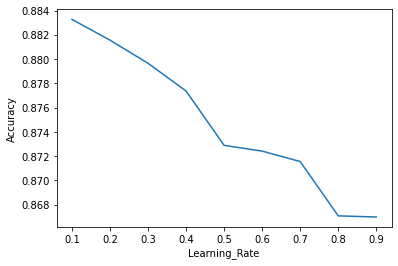

In [ ]:
# Celda 7

accuracy_scores_lr = []

lr_range = np.arange(0.1, 1.0, 0.1)

for lr in lr_range:
    clf_XG = XGBClassifier(learning_rate=lr,verbosity = 0)
    accuracy_scores_lr.append(cross_val_score(clf_XG, X, y, cv=5, scoring='accuracy').mean())

plt.plot(lr_range, accuracy_scores_lr)
plt.xlabel('Learning_Rate')
plt.ylabel('Accuracy')

max_index = accuracy_scores_lr.index(max(accuracy_scores_lr))
print(lr_range[max_index])

9


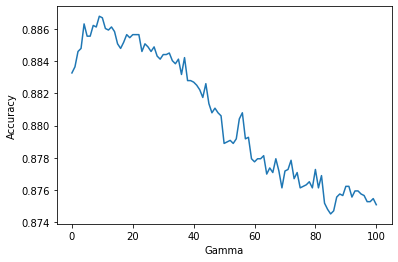

In [ ]:
accuracy_scores_gamma = []

gamma_range = np.arange(0, 101, 1)

for gamma in gamma_range:
    clf_XG = XGBClassifier(learning_rate=0.1,gamma=gamma,verbosity = 0)
    accuracy_scores_gamma.append(cross_val_score(clf_XG, X, y, cv=5, scoring='accuracy').mean())

plt.plot(gamma_range, accuracy_scores_gamma)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

max_index = accuracy_scores_gamma.index(max(accuracy_scores_gamma))
print(gamma_range[max_index])

0.4


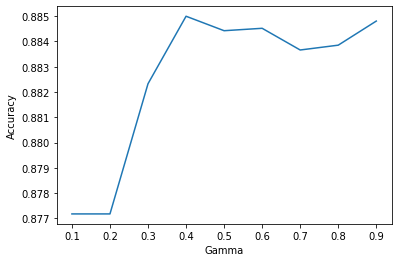

In [ ]:
accuracy_scores_colsam = []

colsam_range = np.arange(0.1, 1.0, 0.1)

for colsam in colsam_range:
    clf_XG = XGBClassifier(learning_rate=0.1,gamma=9,colsample_bytree=colsam ,verbosity = 0)
    accuracy_scores_colsam.append(cross_val_score(clf_XG, X, y, cv=5, scoring='accuracy').mean())

plt.plot(colsam_range, accuracy_scores_colsam)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

max_index = accuracy_scores_colsam.index(max(accuracy_scores_colsam))
print(colsam_range[max_index])

In [ ]:
clf_XGtunning = XGBClassifier(learning_rate=0.1,gamma=9,colsample_bytree=0.4 ,verbosity = 0)
clf_XGtunning.fit(X_train, y_train)

y_pred_XGtunning=clf_XGtunning.predict(X_test)
accuracy=accuracy_score(y_test,y_pred_XGtunning)
accuracy

0.8856812933025404

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
